# Node classification on Cora Dataset using GraphEmbeddingwv

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
from node2vec_algo.word2vec_node2vec import GraphEmbeddingwv

<IPython.core.display.Javascript object>

In [20]:
import os
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import scipy.sparse as sp
import torch
from torch import Tensor
import torch_geometric
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import Planetoid
import networkx as nx
from networkx.algorithms import community

<IPython.core.display.Javascript object>

In [4]:
# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
data_dir = "Data/"
os.makedirs(data_dir, exist_ok=True)

<IPython.core.display.Javascript object>

In [5]:
dataset = Planetoid(root=data_dir, name="Cora")
print("Dataset properties")
print("==============================================================")
print(f"Dataset: {dataset}")  # This prints the name of the dataset
print(f"Number of graphs in the dataset: {len(dataset)}")
print(
    f"Number of features: {dataset.num_features}"
)  # Number of features each node in the dataset has
print(
    f"Number of classes: {dataset.num_classes}"
)  # Number of classes that a node can be classified into

Dataset properties
Dataset: Cora()
Number of graphs in the dataset: 1
Number of features: 1433
Number of classes: 7


<IPython.core.display.Javascript object>

In [6]:
data = dataset[0]
print("Graph properties")
print("==============================================================")

# Gather some statistics about the graph.
print(f"Number of nodes: {data.num_nodes}")  # Number of nodes in the graph
print(f"Number of edges: {data.num_edges}")  # Number of edges in the graph
print(
    f"Average node degree: {data.num_edges / data.num_nodes:.2f}"
)  # Average number of nodes in the graph
print(
    f"Contains isolated nodes: {data.has_isolated_nodes()}"
)  # Does the graph contains nodes that are not connected
print(
    f"Contains self-loops: {data.has_self_loops()}"
)  # Does the graph contains nodes that are linked to themselves
print(f"Is undirected: {data.is_undirected()}")  # Is the graph an undirected graph

Graph properties
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


<IPython.core.display.Javascript object>

In [7]:
print(f"Average node degree: {data.num_edges / data.num_nodes:.2f}")

Average node degree: 3.90


<IPython.core.display.Javascript object>

In [82]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

<IPython.core.display.Javascript object>

In [83]:
G = to_networkx(data, to_undirected=True)

<IPython.core.display.Javascript object>

In [9]:
def loss_function(Z, S):
    """
    Calculate the objective function ||Z^T*Z - S||^2.

    Args:
        Z (numpy.ndarray): The node embeddings as a numpy array.
        S (numpy.ndarray): The similarity matrix.

    Returns:
        float: The value of the objective function.
    """
    Z_transpose = np.transpose(Z)
    diff = np.dot(Z_transpose, Z) - S
    #     obj_func = np.linalg.norm(diff) ** 2
    obj_func = np.linalg.norm(diff)
    return obj_func

<IPython.core.display.Javascript object>

In [10]:
# Define the hyperparameter search space
param_space = {
    "return_param": np.random.uniform(0.0, 4.0, 50),  # Example: random uniform sampling
    "in_out_param": np.random.uniform(0.0, 4.0, 50),  # Example: random uniform sampling
    "num_walks": np.random.randint(3, 12, 8),  # Example: random integer sampling
    "walk_length": np.random.randint(50, 100, 10),  # Example: random integer sampling
    "window_size": np.random.randint(5, 12, 5),  # Example: random integer sampling
    "dimension": np.random.choice([32, 64, 128, 256], 6),  # Example: random choice
    #     "epochs": np.random.choice([10, 20, 30, 50, 60], 5),  # Example: random choice
    "epochs": 100,  # Example: random choice
    "negative": np.random.choice([3, 6], 5),  # Example: random choice
    "batch_words": np.random.choice([8, 16], 5),  # Example: random choice
    "learning_rate": np.random.choice([0.01, 0.0001, 0.02], 10),
    "min_count": np.random.choice([0, 1, 2], 6),
    "weight_decay": np.random.choice([1e-3, 1e-4, 1e-5, 1e-2], 4),
}

best_loss = float("inf")
best_params = None

<IPython.core.display.Javascript object>

In [11]:
# Perform random search
num_iterations = 5  # Adjust the number of iterations as needed


<IPython.core.display.Javascript object>

Training Word2Vec: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:22<00:00,  1.21it/s]


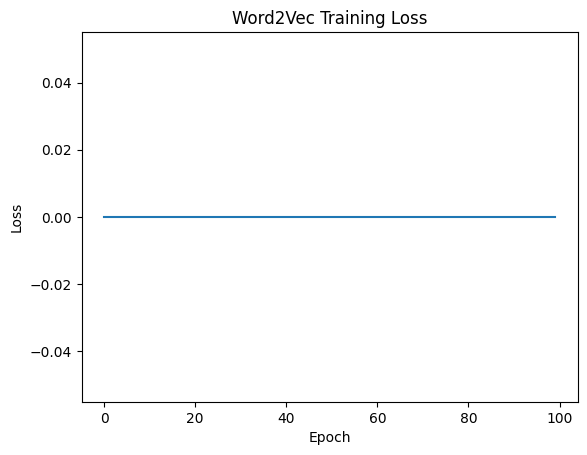

Training Word2Vec: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:03<00:00,  1.83s/it]


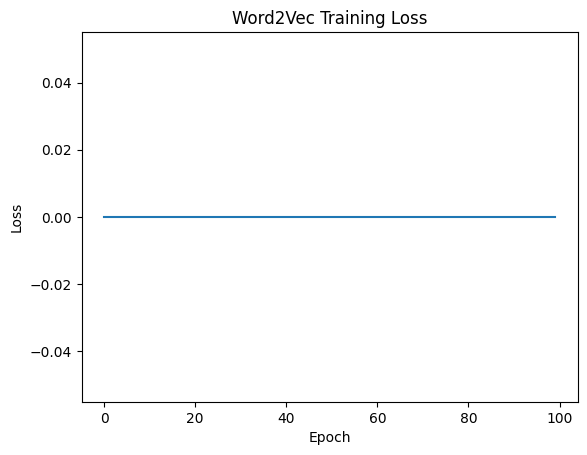

Training Word2Vec: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:51<00:00,  1.11s/it]


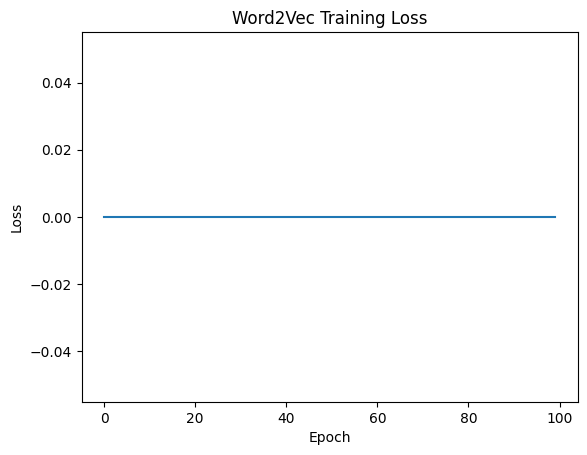

Training Word2Vec: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:36<00:00,  2.76s/it]


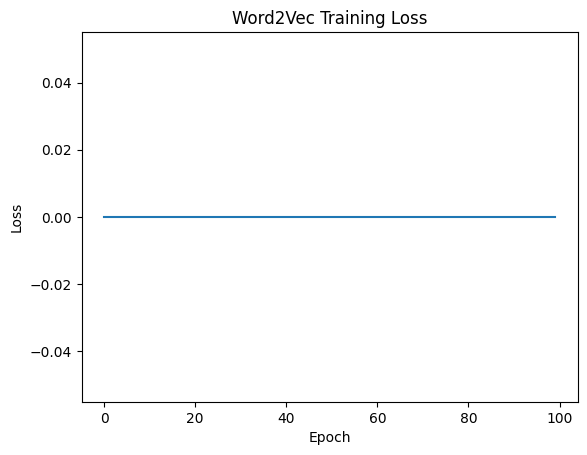

Training Word2Vec: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:19<00:00,  2.00s/it]


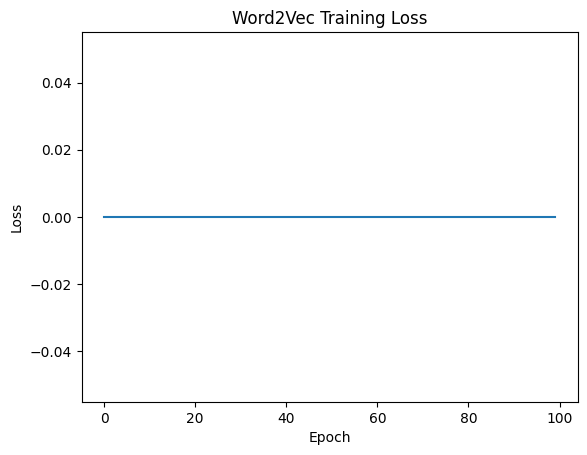

<IPython.core.display.Javascript object>

In [12]:
for _ in range(num_iterations):
    # Randomly sample hyperparameters
    sampled_params = {
        param: np.random.choice(values) for param, values in param_space.items()
    }
    func_los_cal = []

    # Create an instance of your GraphEmbedding class with sampled hyperparameters
    embedding = GraphEmbeddingwv(
        graph=G,
        return_param=sampled_params["return_param"],
        in_out_param=sampled_params["in_out_param"],
        num_walks=sampled_params["num_walks"],
        walk_length=sampled_params["walk_length"],
    )

    probab = embedding.calculate_transition_probabilities()
    # Train and evaluate with the current set of hyperparameters
    walks, uns = embedding.generate_random_walks()
    S = embedding.calculate_probability_matrix(uns)
    node_embeddings = embedding.training(
        walks,
        window_size=sampled_params["window_size"],
        dimension=sampled_params["dimension"],
        sg=1,
        epochs=100,
        #         weight_decay=sampled_params["weight_decay"],
        negative=sampled_params["negative"],
        batch_words=sampled_params["batch_words"],
        learning_rate=sampled_params["learning_rate"],
    )

    Z = node_embeddings.vectors.T
    current_loss = loss_function(Z, S)
    func_los_cal.append(current_loss)

    # Update the best hyperparameters if the current set is better
    if current_loss < best_loss:
        best_loss = current_loss
        best_params = sampled_params

In [13]:
print("Best Hyperparameters:", best_params)
print("Best Loss:", best_loss)

Best Hyperparameters: {'return_param': 2.832290311184182, 'in_out_param': 1.3013213230530574, 'num_walks': 6, 'walk_length': 77, 'window_size': 8, 'dimension': 256, 'epochs': 50, 'negative': 3, 'batch_words': 16, 'learning_rate': 0.0001, 'min_count': 1, 'weight_decay': 0.0001}
Best Loss: 14252.134677182035


<IPython.core.display.Javascript object>

In [23]:
# Convert int32 values to Python integers
for key, value in best_params.items():
    if isinstance(value, np.int32):
        best_params[key] = int(value)

# Save the best hyperparameters to a JSON file
with open("best_hyperparameters.json", "w") as json_file:
    json.dump(best_params, json_file)

<IPython.core.display.Javascript object>

## Generating Embeddings with best paramters

In [16]:
my_embedding_s = GraphEmbeddingwv(
    graph=G,
    return_param=best_params["return_param"],
    in_out_param=best_params["in_out_param"],
    num_walks=best_params["num_walks"],
    walk_length=best_params["walk_length"],
)

<IPython.core.display.Javascript object>

In [17]:
probab_t = my_embedding_s.calculate_transition_probabilities()
walks_s, unshuffled_walks = my_embedding_s.generate_random_walks()
similimat = my_embedding_s.calculate_probability_matrix(unshuffled_walks)

Calculating Probabilities: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2708/2708 [10:48<00:00,  4.18it/s]


<IPython.core.display.Javascript object>

Training Word2Vec: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:57<00:00,  2.34s/it]


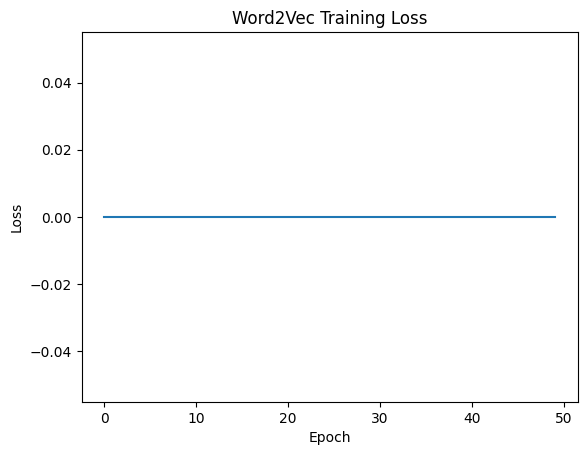

<IPython.core.display.Javascript object>

In [24]:
node_embedding_my_algo = my_embedding_s.training(
    walks,
    window_size=best_params["window_size"],
    dimension=best_params["dimension"],
    sg=1,
    epochs=best_params["epochs"],
    negative=best_params["negative"],
    batch_words=best_params["batch_words"],
    learning_rate=best_params["learning_rate"],
)

In [27]:
z_mat = node_embedding_my_algo.vectors.T

<IPython.core.display.Javascript object>

In [28]:
final_los_sim = loss_function(z_mat, similimat)

<IPython.core.display.Javascript object>

In [29]:
final_los_sim

12621.902887757184

<IPython.core.display.Javascript object>

## Generating Node Embeddings using Node2vec

In [96]:
# from karateclub import Node2Vec
from node2vec import Node2Vec

<IPython.core.display.Javascript object>

In [99]:
node2vec = Node2Vec(
    G,
    walk_length=best_params["walk_length"],
    dimensions=best_params["dimension"],
    p=best_params["return_param"],
    q=best_params["in_out_param"],
    num_walks=best_params["num_walks"],
    workers=4,
)

Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [100]:
model = node2vec.fit(window=best_params["window_size"], min_count=1)

<IPython.core.display.Javascript object>

In [102]:
# Extract node embeddings
node_embeddings_node2vec = {node: model.wv[node] for node in G.nodes()}

<IPython.core.display.Javascript object>

In [103]:
node_embeddings_node2vec

{0: array([ 0.07170331, -0.04807606,  0.15473723,  0.04589933, -0.11106171,
         0.01752334,  0.08030616,  0.00333777, -0.16546929, -0.09558803,
        -0.09818895, -0.01987714,  0.12644622, -0.00712787, -0.04609993,
         0.01818015,  0.2010318 ,  0.22819965, -0.21579765, -0.36820316,
        -0.00612786,  0.27137282,  0.3117476 ,  0.09777641,  0.32437745,
        -0.13905928,  0.29719132,  0.19843765, -0.26096958,  0.09527636,
        -0.09606273,  0.08458213,  0.18599401, -0.14540206,  0.02508759,
        -0.04265612,  0.37921968, -0.201784  , -0.08443107, -0.04164635,
         0.13654317,  0.20364992, -0.32337248,  0.04859651,  0.05762213,
        -0.09278511, -0.03337637,  0.10462177,  0.05914843,  0.14539197,
        -0.18355432,  0.07983658,  0.02299722,  0.10016069, -0.257211  ,
        -0.19179279,  0.22702025,  0.07986981,  0.1579961 ,  0.23509912,
        -0.17835733, -0.05090915, -0.08566964,  0.21710548,  0.20063373,
        -0.18402313,  0.09883042, -0.13354424, -

<IPython.core.display.Javascript object>

In [107]:
# Extract the embeddings from the dictionary values and store them in a list
embeddings_list = list(node_embeddings_node2vec.values())

# Convert the list of embeddings to a NumPy array if needed
embeddings_array = np.array(embeddings_list)

<IPython.core.display.Javascript object>

In [109]:
embeddings_array.shape

(2708, 256)

<IPython.core.display.Javascript object>

## Classification

In [58]:
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score,
)

<IPython.core.display.Javascript object>

In [51]:
# 2. Preprocess Labels
labels = data.y

<IPython.core.display.Javascript object>

In [61]:
labels.shape

(2708,)

<IPython.core.display.Javascript object>

In [69]:
X_train, X_test, y_train, y_test = train_test_split(
    node_embedding_my_algo.vectors, labels, test_size=0.25, random_state=42
)


<IPython.core.display.Javascript object>

In [73]:
logreg = LogisticRegression(max_iter=1000, random_state=42, penalty="l2")

<IPython.core.display.Javascript object>

In [74]:
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

<IPython.core.display.Javascript object>

In [75]:
# After training, you can evaluate the model on the test set
accuracy = logreg.score(X_test, y_test)
print("Accuracy on the test set:", accuracy)

Accuracy on the test set: 0.2776957163958641


<IPython.core.display.Javascript object>

In [76]:
y_pred = logreg.predict(X_test)

<IPython.core.display.Javascript object>

In [77]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.25      0.09      0.13        89
           1       0.00      0.00      0.00        53
           2       0.18      0.12      0.15        99
           3       0.33      0.69      0.45       230
           4       0.11      0.07      0.08       106
           5       0.07      0.03      0.05        59
           6       0.50      0.02      0.05        41

    accuracy                           0.28       677
   macro avg       0.21      0.15      0.13       677
weighted avg       0.23      0.28      0.21       677



<IPython.core.display.Javascript object>

### cliassification of Node2vec embeddings

In [110]:
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(
    embeddings_array, labels, test_size=0.25, random_state=42
)


<IPython.core.display.Javascript object>

In [111]:
logreg_n = LogisticRegression(max_iter=1000, random_state=42, penalty="l2")

<IPython.core.display.Javascript object>

In [112]:
logreg_n.fit(X_train_n, y_train_n)

LogisticRegression(max_iter=1000, random_state=42)

<IPython.core.display.Javascript object>

In [114]:
# After training, you can evaluate the model on the test set
accuracy_n = logreg_n.score(X_test_n, y_test_n)
print("Accuracy on the test set:", accuracy_n)

Accuracy on the test set: 0.23338257016248154


<IPython.core.display.Javascript object>

In [115]:
y_pred_n = logreg_n.predict(X_test_n)

<IPython.core.display.Javascript object>

In [116]:
print(classification_report(y_test_n, y_pred_n))

              precision    recall  f1-score   support

           0       0.11      0.06      0.07        89
           1       0.04      0.02      0.03        53
           2       0.16      0.12      0.14        99
           3       0.34      0.53      0.41       230
           4       0.15      0.14      0.15       106
           5       0.06      0.05      0.05        59
           6       0.06      0.02      0.04        41

    accuracy                           0.23       677
   macro avg       0.13      0.13      0.13       677
weighted avg       0.19      0.23      0.20       677



<IPython.core.display.Javascript object>